In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
# Charger le jeu de données
data = pd.read_csv("data/revenus.csv")

In [2]:
# Première itération
# Remplacer les '?' par NaN pour un traitement plus facile des valeurs manquantes
data.replace('?', pd.NA, inplace=True)

# Étape 1: Encodage des variables catégorielles
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 
                       'relationship', 'race', 'gender', 'native-country', 'income']
label_encoders = {}

# Encoder chaque colonne catégorielle
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col].astype(str))

# Vérification et suppression de la colonne 'fnlwgt' si elle existe
if 'fnlwgt' in data.columns:
    data.drop(columns=['fnlwgt'], inplace=True)

# Exclure 'capital-gain' et 'capital-loss' des variables pour la détection d'anomalies
X_for_outlier_detection = data.drop(columns=['capital-gain', 'capital-loss', 'income'])

# Isolation Forest pour détecter les valeurs aberrantes
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(X_for_outlier_detection)

# Ajouter une colonne pour indiquer les valeurs aberrantes
data['outlier'] = outliers

# Afficher les premières lignes des données après avoir marqué les valeurs aberrantes
print("\nDonnées après Isolation Forest (1 = non-aberrant, -1 = aberrant) :")
print(data[['age', 'workclass', 'capital-gain', 'capital-loss', 'outlier']].head())

# Garder uniquement les points qui ne sont pas des anomalies
data_cleaned = data[data['outlier'] == 1].drop(columns=['outlier'])

# Afficher les premières lignes des données après suppression des valeurs aberrantes
print("\nDonnées après suppression des valeurs aberrantes :")
print(data_cleaned[['age', 'workclass', 'capital-gain', 'capital-loss']].head())


Données après Isolation Forest (1 = non-aberrant, -1 = aberrant) :
   age  workclass  capital-gain  capital-loss  outlier
0   25          4             0             0        1
1   38          4             0             0        1
2   28          2             0             0        1
3   44          4          7688             0        1
4   18          0             0             0        1

Données après suppression des valeurs aberrantes :
   age  workclass  capital-gain  capital-loss
0   25          4             0             0
1   38          4             0             0
2   28          2             0             0
3   44          4          7688             0
4   18          0             0             0


In [3]:
# Étape 2: Normalisation des données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


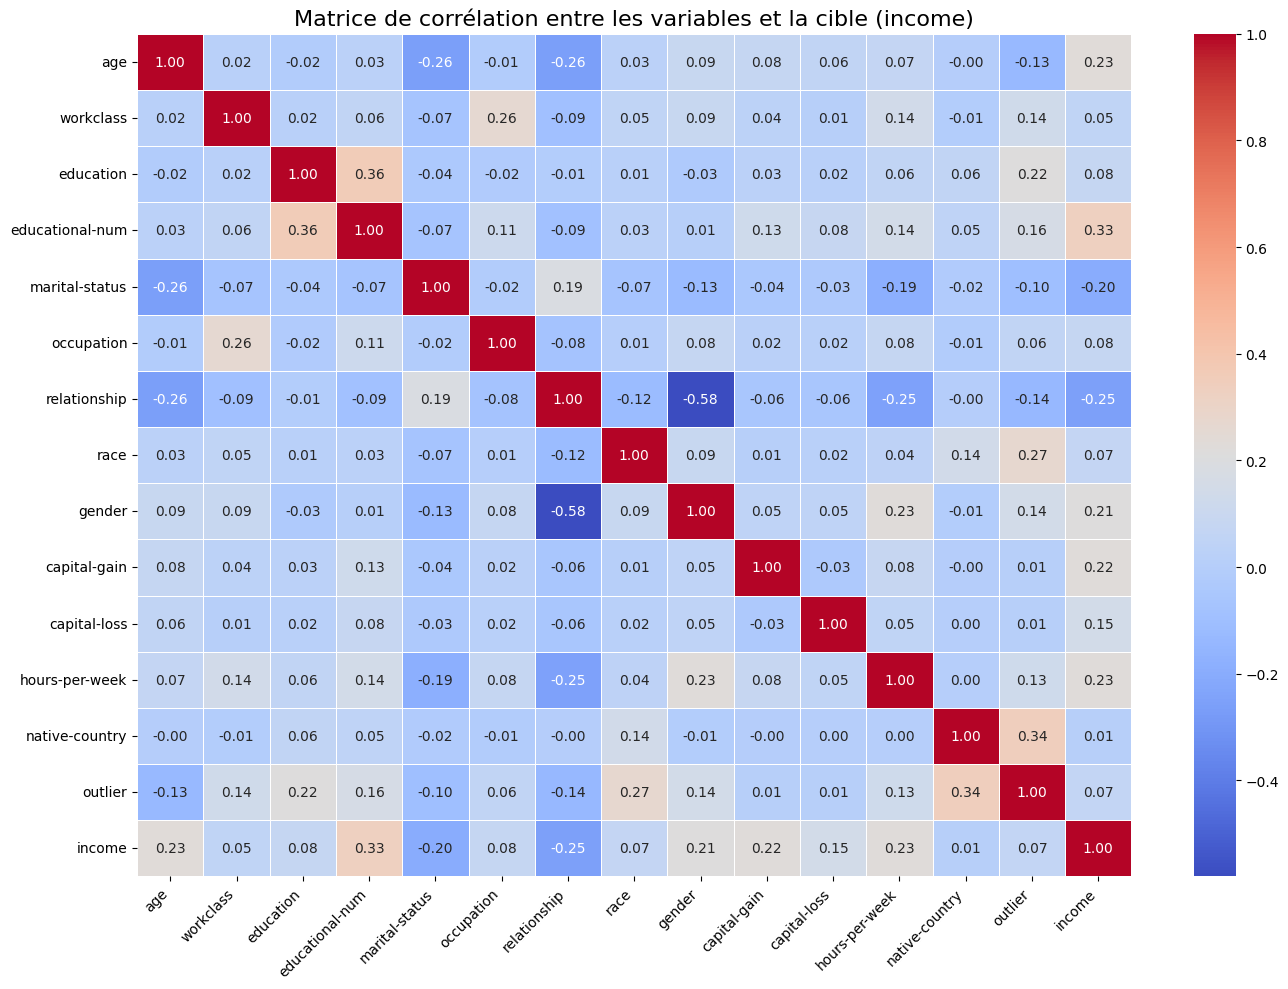

In [4]:
# Étape 3: Imputation des valeurs manquantes par KNN
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(scaled_data)

# Convertir les données imputées en DataFrame
imputed_data = pd.DataFrame(imputed_data, columns=data.columns)



# Récupérer la variable cible (income) sous sa forme originale encodée en 0 et 1
y = data['income']  # Réutiliser la variable d'origine (non normalisée)

# Diviser les données en variables explicatives et cible
X = imputed_data.drop(columns=['income'])

# ### Présentation des corrélations ###
# Ajouter la colonne income au DataFrame des variables pour calculer les corrélations
correlation_matrix = pd.concat([X, y], axis=1).corr()

# Visualisation des corrélations
plt.figure(figsize=(14, 10))  # Augmenter la taille de la figure pour plus de clarté
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 10})
plt.title("Matrice de corrélation entre les variables et la cible (income)", fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes pour une meilleure lisibilité
plt.yticks(rotation=0)
plt.tight_layout()  # Ajuster automatiquement les marges
plt.show()

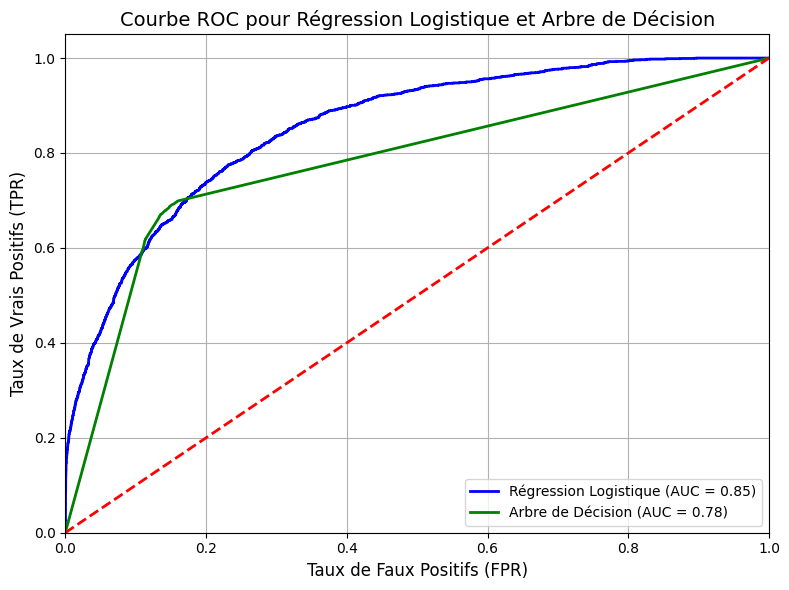


Régression Logistique :
Accuracy: 0.8274
F1-Score: 0.5497
AUC: 0.8545

Arbre de Décision :
Accuracy: 0.8232
F1-Score: 0.6217
AUC: 0.7795


In [5]:
# Étape 4: Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement des modèles
# Modèle de régression logistique
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Modèle d'arbre de décision
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Prédictions
y_pred_prob_log_reg = log_reg.predict_proba(X_test)[:, 1]  # Probabilité que la classe soit 1
y_pred_prob_tree = decision_tree.predict_proba(X_test)[:, 1]

# Calcul des courbes ROC
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_prob_log_reg)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_prob_tree)

# Calcul des AUC
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
roc_auc_tree = auc(fpr_tree, tpr_tree)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, color='blue', lw=2, label=f'Régression Logistique (AUC = {roc_auc_log_reg:.2f})')
plt.plot(fpr_tree, tpr_tree, color='green', lw=2, label=f'Arbre de Décision (AUC = {roc_auc_tree:.2f})')

# Ajout de la diagonale
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)

# Paramètres de la courbe
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbe ROC pour Régression Logistique et Arbre de Décision', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Affichage des résultats
log_reg_metrics = {
    "Accuracy": accuracy_score(y_test, log_reg.predict(X_test)),
    "F1-Score": f1_score(y_test, log_reg.predict(X_test)),
    "AUC": roc_auc_log_reg
}

tree_metrics = {
    "Accuracy": accuracy_score(y_test, decision_tree.predict(X_test)),
    "F1-Score": f1_score(y_test, decision_tree.predict(X_test)),
    "AUC": roc_auc_tree
}

print("\nRégression Logistique :")
for metric, value in log_reg_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nArbre de Décision :")
for metric, value in tree_metrics.items():
    print(f"{metric}: {value:.4f}")

/var/folders/rc/xhmcyg0x1d9b_n3m80ww6sxr0000gn/T/ipykernel_5625/2561871220.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  interactions[f'{col1}_per_{col2}'] = data[col1] / (data[col2] + 1e-5)  # Ajout d'un epsilon pour éviter la division par zéro
/var/folders/rc/xhmcyg0x1d9b_n3m80ww6sxr0000gn/T/ipykernel_5625/2561871220.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  interactions[f'{col2}_per_{col1}'] = data[col2] / (data[col1] + 1e-5)
/var/folders/rc/xhmcyg0x1d9b_n3m80ww6sxr0000gn/T/ipykernel_5625/2561871220.py:22: P

AUC_log_reg: 0.9098479417630696
F1_log_reg: 0.6626564786213623
Accuracy_log_reg: 0.858390773220501
AUC_tree: 0.8911507733843942
F1_tree: 0.6167146974063401
Accuracy_tree: 0.8547737664642053


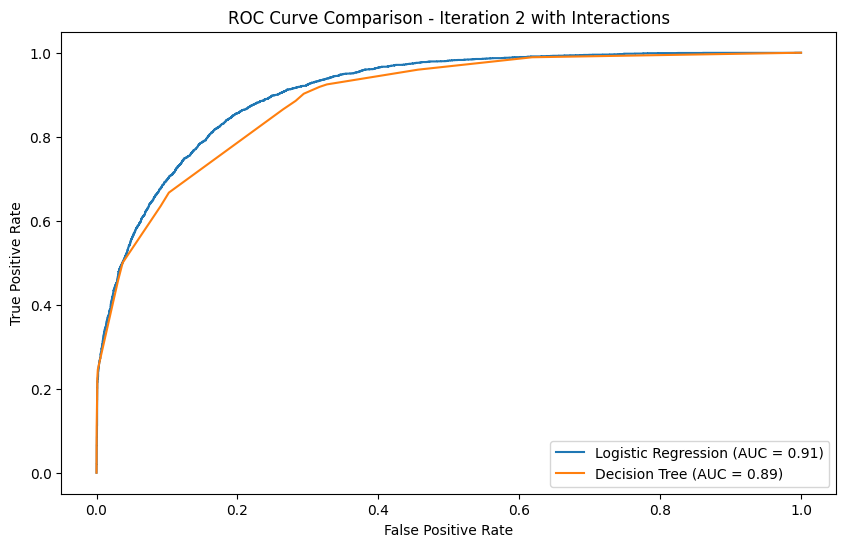

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import itertools

# Charger les données
# data = pd.read_csv('votre_fichier.csv')  # Remplacer par le chemin vers votre fichier de données

# Fonction pour générer toutes les interactions possibles entre les variables
def generate_interactions(data):
    columns = data.columns
    interactions = pd.DataFrame(index=data.index)  # Créer un dataframe vide avec le même index que les données originales

    # Boucle sur toutes les paires de colonnes (combinations)
    for col1, col2 in itertools.combinations(columns, 2):
        # Créer le produit entre les deux colonnes
        interactions[f'{col1}_x_{col2}'] = data[col1] * data[col2]
        # Créer le ratio entre les deux colonnes (éviter les divisions par 0)
        interactions[f'{col1}_per_{col2}'] = data[col1] / (data[col2] + 1e-5)  # Ajout d'un epsilon pour éviter la division par zéro
        interactions[f'{col2}_per_{col1}'] = data[col2] / (data[col1] + 1e-5)
    
    return interactions

# Séparation des variables explicatives et de la cible
X = data.drop(columns=['income'])  # Remplacer 'target' par le nom de votre colonne cible
y = data['income']

# Création de nouvelles variables (feature engineering)

# 1. Transformations non linéaires
X['log_capital_gain'] = np.log1p(X['capital-gain'])  # log(1 + capital-gain) pour éviter log(0)
X['sqrt_age'] = np.sqrt(X['age'])  # Racine carrée de l'âge

# 2. Interactions entre toutes les variables
X_interactions = generate_interactions(X)

# Combiner les nouvelles interactions avec le DataFrame d'origine
X_combined = pd.concat([X, X_interactions], axis=1)

# 3. Variables booléennes (indicateurs)
X_combined['has_capital_gain'] = (X_combined['capital-gain'] > 0).astype(int)  # Indicateur si capital-gain > 0
X_combined['is_senior'] = (X_combined['age'] > 50).astype(int)  # Indicateur pour les âges supérieurs à 50 ans

# Split des données en entraînement et test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

# Normalisation des variables numériques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Régression logistique
log_reg = LogisticRegression(solver='liblinear', penalty='l2', C=1.0)  # On reste simple pour cette itération
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Calcul des métriques pour la régression logistique
auc_log_reg = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
f1_log_reg = f1_score(y_test, y_pred_log_reg)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)

print(f"AUC_log_reg: {auc_log_reg}")
print(f"F1_log_reg: {f1_log_reg}")
print(f"Accuracy_log_reg: {accuracy_log_reg}")

# 2. Arbre de décision
tree_clf = DecisionTreeClassifier(max_depth=5, min_samples_split=10)  # On reste simple ici aussi
tree_clf.fit(X_train_scaled, y_train)
y_pred_tree = tree_clf.predict(X_test_scaled)

# Calcul des métriques pour l'arbre de décision
auc_tree = roc_auc_score(y_test, tree_clf.predict_proba(X_test_scaled)[:, 1])
f1_tree = f1_score(y_test, y_pred_tree)
accuracy_tree = accuracy_score(y_test, y_pred_tree)

print(f"AUC_tree: {auc_tree}")
print(f"F1_tree: {f1_tree}")
print(f"Accuracy_tree: {accuracy_tree}")

# Comparaison des résultats avec courbe ROC
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
fpr_tree, tpr_tree, _ = roc_curve(y_test, tree_clf.predict_proba(X_test_scaled)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_log_reg, tpr_log_reg, label='Logistic Regression (AUC = {:.2f})'.format(auc_log_reg))
plt.plot(fpr_tree, tpr_tree, label='Decision Tree (AUC = {:.2f})'.format(auc_tree))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - Iteration 2 with Interactions')
plt.legend()
plt.show()

In [13]:
from sklearn.decomposition import PCA
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Appliquer PCA pour réduire la dimensionnalité

# Initialiser la PCA avec 99% de la variance expliquée
pca = PCA(n_components=0.99)

# Ajuster la PCA sur les données d'entraînement et les transformer
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Nombre de composantes après PCA : {X_train_pca.shape[1]}")

# 3. Optimisation de la régression logistique avec Optuna

def objective_log_reg(trial):
    # Hyperparamètres à optimiser avec Optuna
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.01, 10, log=True)  # C pour la régularisation, plage réduite avec log scale
    
    # Création du modèle de régression logistique avec les hyperparamètres choisis
    log_reg = LogisticRegression(penalty=penalty, C=C, solver='saga', max_iter=1000)  # Utilisation du solver 'saga' plus rapide
    
    # Entraînement du modèle
    log_reg.fit(X_train_pca, y_train)
    
    # Prédictions et évaluation sur l'ensemble de test
    y_pred_proba = log_reg.predict_proba(X_test_pca)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    return auc_score  # Objectif à maximiser

# Étudier et optimiser la régression logistique avec Optuna
study_log_reg = optuna.create_study(direction='maximize')
study_log_reg.optimize(objective_log_reg, n_trials=30)  # Réduction du nombre de trials pour gagner du temps

# Meilleur ensemble d'hyperparamètres
best_params_log_reg = study_log_reg.best_params
print(f"Meilleurs hyperparamètres pour la Régression Logistique : {best_params_log_reg}")

# Entraînement du meilleur modèle
best_log_reg = LogisticRegression(**best_params_log_reg, solver='saga', max_iter=1000)
best_log_reg.fit(X_train_pca, y_train)

# Prédictions et évaluation
y_pred_log_reg = best_log_reg.predict(X_test_pca)
auc_log_reg = roc_auc_score(y_test, best_log_reg.predict_proba(X_test_pca)[:, 1])
f1_log_reg = f1_score(y_test, y_pred_log_reg)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)

print(f"AUC_log_reg (Optimisé avec Optuna) : {auc_log_reg}")
print(f"F1_log_reg (Optimisé avec Optuna) : {f1_log_reg}")
print(f"Accuracy_log_reg (Optimisé avec Optuna) : {accuracy_log_reg}")



[I 2024-10-24 18:01:46,105] A new study created in memory with name: no-name-7f6c718b-af79-4a69-b452-79a6df6a4bab


Nombre de composantes après PCA : 128


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-10-24 18:02:33,254] Trial 0 finished with value: 0.9074477195689601 and parameters: {'penalty': 'l1', 'C': 0.2238929462837137}. Best is trial 0 with value: 0.9074477195689601.
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-10-24 18:03:03,030] Trial 1 finished with value: 0.9073834769421553 and parameters: {'penalty': 'l2', 'C': 1.7320524912655424}. Best is trial 0 with value: 0.9074477195689601.
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  wa

Meilleurs hyperparamètres pour la Régression Logistique : {'penalty': 'l2', 'C': 0.03048020090703605}
AUC_log_reg (Optimisé avec Optuna) : 0.9075316540706346
F1_log_reg (Optimisé avec Optuna) : 0.6561576354679803
Accuracy_log_reg (Optimisé avec Optuna) : 0.8570941104210742


In [14]:
# 4. Optimisation de l'arbre de décision avec Optuna

def objective_tree(trial):
    # Hyperparamètres à optimiser avec Optuna
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    
    # Création du modèle d'arbre de décision avec les hyperparamètres choisis
    tree_clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    
    # Entraînement du modèle
    tree_clf.fit(X_train_pca, y_train)  # Utilisation des données PCA ici, sans interactions polynomiales
    
    # Prédictions et évaluation sur l'ensemble de test
    y_pred_proba = tree_clf.predict_proba(X_test_pca)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    return auc_score  # Objectif à maximiser



In [15]:
# Étudier et optimiser l'arbre de décision avec Optuna
study_tree = optuna.create_study(direction='maximize')
study_tree.optimize(objective_tree, n_trials=20)  # Réduction du nombre de trials pour gagner du temps

# Meilleur ensemble d'hyperparamètres
best_params_tree = study_tree.best_params
print(f"Meilleurs hyperparamètres pour l'Arbre de Décision : {best_params_tree}")

# Entraînement du meilleur modèle
best_tree_clf = DecisionTreeClassifier(**best_params_tree)
best_tree_clf.fit(X_train_pca, y_train)

# Prédictions et évaluation
y_pred_tree = best_tree_clf.predict(X_test_pca)
auc_tree = roc_auc_score(y_test, best_tree_clf.predict_proba(X_test_pca)[:, 1])
f1_tree = f1_score(y_test, y_pred_tree)
accuracy_tree = accuracy_score(y_test, y_pred_tree)

print(f"AUC_tree (Optimisé avec Optuna) : {auc_tree}")
print(f"F1_tree (Optimisé avec Optuna) : {f1_tree}")
print(f"Accuracy_tree (Optimisé avec Optuna) : {accuracy_tree}")



[I 2024-10-24 18:17:12,038] A new study created in memory with name: no-name-ac112016-d353-4805-8670-4dc2584cfbb8
[I 2024-10-24 18:17:14,869] Trial 0 finished with value: 0.8717992178434156 and parameters: {'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8717992178434156.
[I 2024-10-24 18:17:17,951] Trial 1 finished with value: 0.8797834206127205 and parameters: {'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8797834206127205.
[I 2024-10-24 18:17:21,830] Trial 2 finished with value: 0.8810400043106075 and parameters: {'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8810400043106075.
[I 2024-10-24 18:17:26,566] Trial 3 finished with value: 0.8666603803642464 and parameters: {'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8810400043106075.
[I 2024-10-24 18:17:29,580] Trial 4 finished with value: 0.87935

Meilleurs hyperparamètres pour l'Arbre de Décision : {'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4}
AUC_tree (Optimisé avec Optuna) : 0.8822700371659734
F1_tree (Optimisé avec Optuna) : 0.6161153519932145
Accuracy_tree (Optimisé avec Optuna) : 0.8455606360472259


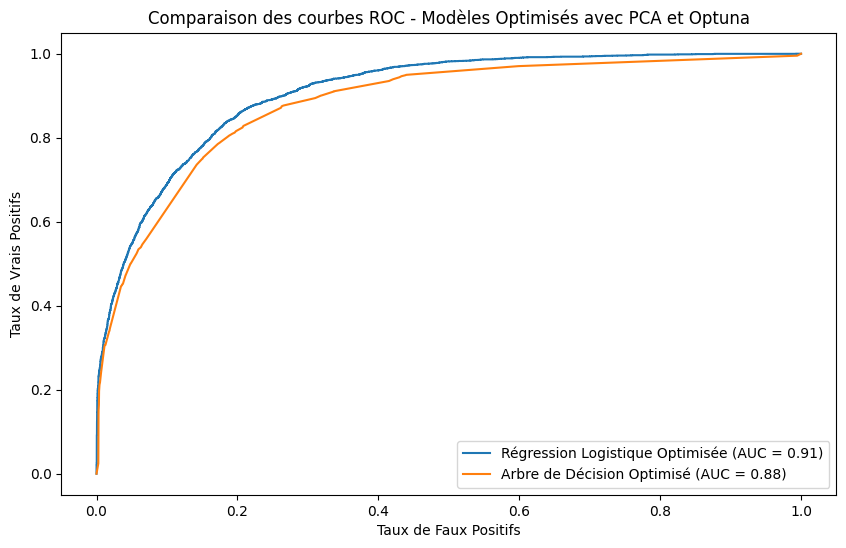

In [16]:
# Comparaison des résultats avec courbe ROC
from sklearn.metrics import roc_curve

fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, best_log_reg.predict_proba(X_test_pca)[:, 1])
fpr_tree, tpr_tree, _ = roc_curve(y_test, best_tree_clf.predict_proba(X_test_pca)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_log_reg, tpr_log_reg, label='Régression Logistique Optimisée (AUC = {:.2f})'.format(auc_log_reg))
plt.plot(fpr_tree, tpr_tree, label='Arbre de Décision Optimisé (AUC = {:.2f})'.format(auc_tree))
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Comparaison des courbes ROC - Modèles Optimisés avec PCA et Optuna')
plt.legend()
plt.show()